In [6]:
import numpy as np
import pandas as pd
import math as m
import sympy as sym
import random as rand
import matplotlib.pyplot as plt
import cmath as cm
from IPython.display import display, Latex

In [7]:
def Creating_states( coeff = [1/(2**.5),1/(2**.5),1/(2**.5),1/(2**.5)] , Abstract = False):    # coeff list like [a0,a1,b0,b1]
    if Abstract == True:
        a0 = sym.symbols('a0')
        a1 = sym.symbols('a1')
        b0 = sym.symbols('b0')
        b1 = sym.symbols('b1')
    else:
        a0 = coeff[0]
        a1 = coeff[1]
        b0 = coeff[2]
        b1 = coeff[3]
    psi0 = [a0,a1]      # defining states
    psi1 = [b0,b1]
    return([psi0,psi1])


initial_states = Creating_states(Abstract=False, coeff = [1/(2**.5),1/(2**.5),1,0])     # Creating the two states with these coefficients

psi0 = initial_states[0]
psi1 = initial_states[1]

psi0sq = []
psi1sq = []
[[psi0sq.append(i*j) for i in psi0] for j in psi0]
[[psi1sq.append(i*j) for i in psi1] for j in psi1]   # creating list of coeff for squared states (intermeditate step)

psi0psi0 = [psi0sq[0], (psi0sq[1]**2+psi0sq[2]**2)**(.5), psi0sq[3]]        # the second element is the normalized coefficient due to the addition of states (01+10). See OneNote writeup for details
psi1psi1 = [psi1sq[0], (psi1sq[1]**(2)+psi1sq[2]**(2))**(.5), psi1sq[3]]            # symmetric states in basis (|00>, normalized version of (|01>+|10>),|11>)

# Creating theoretical Rho matrix
vec_psi0psi0 = np.array(psi0psi0)     # convertying to numpy arrays
vec_psi1psi1 = np.array(psi1psi1)

rho = (1/2)*(np.outer(vec_psi0psi0, vec_psi0psi0)+np.outer(vec_psi1psi1, vec_psi1psi1))       # density matrix with priors 1/2 each.


Original Individual code (later has pretty much everything in a compact function)

In [8]:


# creating the SIC POVM matrices
w = m.e**((2/3)*m.pi*(1j))     # the w in the notes
POVM_vec = (1/(2**.5))*(np.array([[0,1,-1],[-1,0,1],[1,-1,0],[0,w,-w**2],[-1,0,w**2],[1,-w,0],[0,w**2,-w],[-1,0,w],[1,-w**2,0]]))  # an array of POVM direction vectors
POVM_elts = [(1/3)*np.outer(np.conjugate(POVM_vec[i]),POVM_vec[i]) for i in range(len(POVM_vec))]   # a list of POVM matrices

# sum([np.trace(POVM_elts[i]) for i in range(9)])     # trace sum = 3 = Tr(Identity_(3X3)) , verified   

prob_vec_raw =  [np.trace(np.dot(POVM_elts[i],rho)) for i in range(9)]  #[(POVM_elts[i]*rho).trace() for i in range(len(POVM_elts))]
prob_vec = [i.real for i in prob_vec_raw if abs(i.imag) < .01]          # cleaned up the trailing imaginary parts

# sum(prob_vec)        # sum prob = 1, verified



#Experimental part
N = 10000       # number of measurements  
POVM_dir_symbols = ['d1','d2','d3','d4','d5','d6','d7','d8','d9']       # symbols to indicate collapsed direction
#prob distribution is simply the corresponding elements of the prob_vec
collapse_dir_vec = rand.choices(POVM_dir_symbols, weights=prob_vec, k = N)   #choosing collapse directions with weights for N trials

nj_vec = [collapse_dir_vec.count(f'd{i+1}') for i in range(9)]
pj_num_vec = [i/N for i in nj_vec]      
# ([i*N for i in prob_vec] , nj_vec)   # comparing the theoretical and experimental collapse probabilities, verified



# finding r vector
M = [[np.trace(np.dot(POVM_elts[i],POVM_elts[j])) for i in range(len(POVM_elts))] for j in range(len(POVM_elts))]     # creating M matrix using POVM definition

u_0 = [1/3 for i in range(9)]           # cerating u_0 vector, to create the inverse matrix
M_inv = 3*np.outer(u_0,u_0) + 12*(np.eye(9) - np.outer(u_0,u_0))        # creating the inverse matrix
# np.trace(np.dot(M,M_inv))       # gives identity, checks out
r_vec = np.dot(M_inv,pj_num_vec)


#Reconstructing numerical rho
rho_num_list = [r_vec[i]*POVM_elts[i] for i in range(len(POVM_elts))]   # list of matrices, see equation 7 in notes pair_disc.pdf
rho_num = np.zeros_like(rho_num_list[0])

# Loop over the matrices and sum them element-wise to find the numerically reconstructed rho
for matrix in rho_num_list:
    rho_num = np.add(rho_num, matrix)

# print('Numerical rho:\n', rho_num) 
    
#Error Stuff   
del_rho = rho_num-rho  # defining the difference of numberical and theoretical state
# del_rho

eigenvalues, eigenvectors = np.linalg.eig(del_rho)  # each COLUMN is the corresponding eigenvector and not the row. eigenvectors[:,0]
# eigenvectors[:,0]   # eigenvector correspoding to the first eigenvalue
evals = np.array([i.real for i in eigenvalues if abs(i.imag)< .001])
norm_del_rho = max([abs(i) for i in evals])     # picking out the largest magnitude evalue

# norm_del_rho    # "error in the density matrices"

Pretty much everything above combined into a function for the sake of ease

In [9]:
#Creating function for the sake of ease, for the error in the density matrices. This plots 
def experiment_rho(N = 10000, coeff = [1,0,0,1], priors = [.5,.5], show_calcs = False):
    initial_states = Creating_states(Abstract=False, coeff = coeff)     # Creating the two states with these coefficients
    psi0 = initial_states[0]
    psi1 = initial_states[1]    # created the states to be discriminated

    psi0sq = []
    psi1sq = []
    [[psi0sq.append(i*j) for i in psi0] for j in psi0]
    [[psi1sq.append(i*j) for i in psi1] for j in psi1]   
    psi0psi0 = [psi0sq[0], (psi0sq[1]**2+psi0sq[2]**2)**(.5), psi0sq[3]]    
    psi1psi1 = [psi1sq[0], (psi1sq[1]**(2)+psi1sq[2]**(2))**(.5), psi1sq[3]]    # creating square states
    
    vec_psi0psi0 = np.array(psi0psi0)     
    vec_psi1psi1 = np.array(psi1psi1)
    rho = priors[0]*np.outer(vec_psi0psi0, vec_psi0psi0)+ priors[1]*np.outer(vec_psi1psi1, vec_psi1psi1)     # theoretical density matrix with priors 1/2 each.

    prob_vec =  [np.trace(np.dot(POVM_elts[i],rho)) for i in range(9)] 
    prob_vec = [round(i.real, 5) for i in prob_vec if abs(i.imag) < .01]          # cleaned up theoretical prob vector

    POVM_dir_symbols = ['d1','d2','d3','d4','d5','d6','d7','d8','d9']      # symbols to indicate collapsed direction
    #prob distribution is simply the corresponding elements of the prob_vec
    collapse_dir_vec = rand.choices(POVM_dir_symbols, weights=prob_vec, k = N)   # choosing collapse directions with weights for N trials

    nj_vec = [collapse_dir_vec.count(f'd{i+1}') for i in range(9)]
    pj_num_vec = [i/N for i in nj_vec]                                  # numerical prob vector     
    
    r_vec = np.dot(M_inv,pj_num_vec)
    
    # constructing the rho numrical using the r_vector etc.
    rho_num_list = [r_vec[i]*POVM_elts[i] for i in range(len(POVM_elts))]   # list of matrices, see equation 7 in Hillery notes pair_disc.pdf
    rho_num_raw = np.zeros_like(rho_num_list[0])
    for matrix in rho_num_list:
        rho_num_raw = np.add(rho_num_raw, matrix)       # created the numerical rho
    
    rho_num = np.real_if_close(np.around(rho_num_raw, decimals=5))
    del_rho = rho_num-rho 
    
    eigenvalues, eigenvectors = np.linalg.eig(del_rho)  # each COLUMN is the corresponding eigenvector and not the row. eigenvectors[:,0]
    # eigenvectors[:,0]   # eigenvector correspoding to the first eigenvalue
    evals = np.array([i.real for i in eigenvalues if abs(i.imag)< .001])    # cleaning up
    evecs = np.real_if_close(np.around(eigenvectors, decimals=3))

    norm_del_rho = max([abs(i) for i in evals])     # picking out the largest magnitude evalue
    error = norm_del_rho

    if show_calcs == True:
        # Display states in LateX
        latex_psi0 = r'\Psi_0 = {}|0\rangle + {}|1\rangle'.format(psi0[0],psi0[1])
        latex_psi1 = r'\Psi_1 = {}|0\rangle + {}|1\rangle'.format(psi1[0],psi1[1])
        display(Latex(f'${latex_psi0}$'))
        display(Latex(f'${latex_psi1}$'))

        # Printing other parameters
        print('\n Rho_Theorectical = \n', rho)

        print('\n Prob_theory = ', prob_vec)
        print('Prob_numerical = ', pj_num_vec)

        print('Rho_Numerical_raw = \n', rho_num_raw )
        print('\n Rho_Numerical = \n', rho_num )
        
        print('\nDifference (rho-rho_num) = \n ', del_rho )
        
        print('\n evals of del_rho= \n ', evals)
        print('\n evecs of del_rho= \n ', evecs)
        
        spectral_reconstruction_DelRho = evals[0]*np.outer(evecs[:,0], evecs[:,0])+evals[1]*np.outer(evecs[:,1], evecs[:,1])+evals[2]*np.outer(evecs[:,2], evecs[:,2])  # verifying spectral decomposition, and that indeed the columns r the evecs
        print('Spectra_reconstruction = \n',spectral_reconstruction_DelRho)
        
        print('\n largest mod eval (error) =' , error)
    return [error, rho, rho_num, evals, evecs]

# experiment_rho(10000, [1,0,0,1],[.5,.5], True)     # Example. prints intermediate quantites for analysis.


In [10]:
# defining solving the quadratic equation fn
def solve_quadratic(a, b, c):
    d = (b**2) - (4*a*c)
    sol1 = (-b-np.sqrt(d))/(2*a)
    sol2 = (-b+np.sqrt(d))/(2*a)
    return [sol1, sol2]

In [771]:
# Fidelity Function
def fid( N = 1000,c = [1,0,0,1], p = [.5,.5], threshold = .05):
    rho = experiment_rho(N= N, coeff=c, priors= p, show_calcs= False)[1]
    rho_expt = experiment_rho(N= N, coeff=c, priors= p, show_calcs= False)[2]
    eigenvalues, eigenvectors = np.linalg.eig(rho_expt) 
    evals = np.array([i.real for i in eigenvalues if abs(i.imag)< .001])
    evecs = np.real_if_close(np.around(eigenvectors, decimals=3))
    min_eval = np.min([abs(i) for i in evals])
    xi = evecs[:, np.argmin([abs(i) for i in evals])]     # xi vector is same as the vector 
    c00,c01,c11 = xi[0],xi[1],xi[2]                         #...corresponding to the minimum eval

    # print('evals=', evals )
    # print('evecs=', evecs)
    # print('min eval=', min_eval)
    

    c_raw = 0

    if abs(c00) > threshold and abs(c11) > threshold:               # use red dot black dot sketch 
        z_a,z_b =solve_quadratic(c00, 2*c01, c11)[0], solve_quadratic(c00, 2*c01, c11)[1]   #...if need to 
        a1 = (1/(np.sqrt(1+abs(z_a)**2)))                           #... understand the logic of <= signs 
        a0 = np.conj(z_a)*a1
        b1 = (1/(np.sqrt(1+abs(z_b)**2)))
        b0 = np.conj(z_b)*b1
        # print('z_a, z_b = ',z_a, z_b)
        c_raw = [a0,a1,b0,b1]
    elif abs(c00) <= threshold and abs(c11) > threshold:
        a0, a1 = 1,0        # random choice, matching later
        z = np.conj((-c11)/(2*c01))     # z defined as (a0*/a1*)
        b1= (1/(np.sqrt(1+abs(z)**2))) 
        b0= np.conj(z)*b1
        # print('condition #2, z = ',z)
        c_raw = [a0,a1,b0,b1]
    elif abs(c00) > threshold and abs(c11) <= threshold:
        a0, a1 = 0,1        
        z = np.conj((-2*c01)/(c00))      # z defined as (b0*/b1*)
        b1= (1/(np.sqrt(1+abs(z)**2))) 
        b0= np.conj(z)*b1
        # print('condition #3, z = ',z)
        c_raw = [a0,a1,b0,b1]
    elif abs(c00) <= threshold and abs(c11) <= threshold:
        a0, a1 = 0,1        
        b0, b1 = 1,0     
        c_raw = [a0,a1,b0,b1]
        # print('condition #4')

    # print('c raw = ', c_raw)
    # print('type c raw = ', type(c_raw))
    
    # c_raw = [a0,a1,b0,b1]
    # c_raw = [np.round(i,6) for i in c_raw]
    # c_raw = [np.round(, 6), np.round(a1, 6), np.round(b0, 6), np.round(b1, 6)]
        
    # fidelity as measure
    f00 = (abs((c_raw[0]*c[0]+c_raw[1]*c[1])))**2
    f01 = (abs((c_raw[0]*c[2]+c_raw[1]*c[3])))**2
    f10 = (abs((c_raw[2]*c[0]+c_raw[3]*c[1])))**2
    f11 = (abs((c_raw[2]*c[2]+c_raw[3]*c[3])))**2


    if  (f00 + f11) > (f01+ f10) :       # sum of angle is bad for mis-assigned vecs
        c_num = c_raw
    else:
        c_num = [c_raw[2],c_raw[3],c_raw[0],c_raw[1]]


    F_a = (abs(sum([np.conj(c[i])*c_num[i] for i in range(0,2)])))**2
    F_b = (abs(sum([np.conj(c[i])*c_num[i] for i in range(2,4)])))**2
    
    # print('\n')
    # print('xi=', xi)
    # print('\n')
    
    # print('c raw = ', c_raw)
    # print('type c raw = ', type(c_raw))
    # print('Numeriacl', c_num)
    # print('\n')
    # print('Theoretical', c)
    
    # # print('metric fids = ', [f00,f01], [f10,f11])
    # print('\n')
    # print('Fidelity', [F_a,F_b])

    return [[xi], '', c , c_num, [F_a,F_b]]



In [796]:
# RoughPad for Trials
c90 = [0,1,1,0]
c90e = [0,1,-1,0]
# c450 = [.707,.707,0,1]
# c45e = [-.707,.707,-1,0]

fid(c=c90, threshold=.05, N = 100)
# fid(c=c90, threshold=.05, N = 1000000)

[[array([-0.062+0.107j,  0.991+0.j   , -0.048-0.028j])],
 '',
 [0, 1, 1, 0],
 [(0.02425759490086282-0.01412200973979505j),
  0.9996059913438567,
  (0.49962795547379957-0.8639920214543121j),
  0.06236740312344705],
 [0.9992121379305346, 0.9961103070276376]]

In [762]:
# Plotting function for both quantities

def Plotting(N = 10000, c = [1,0,0,1], p = [.5,.5], step = 100, metric = 'f', size = [3,3], k = 10):        # function to plot error vs trials plot. N,c,p are Number of trials, coefficients and priors
    count = N//step
    trials_list = [step*(i+1) for i in range(count)]    # only works if N is a multiple of 100
    sqrtN = [2.6/((i+1)**.5) for i in trials_list]    #ideal square root shape with a constant multiplied for scaling
    sqrt_fid = [(1-1/(np.sqrt(k*i+1))) for i in range(N)]   # k is steepness
    if metric == 'f':
        label_0 = r' Fidelity $| \Psi_0 \rangle $'
        label_1 = r' Fidelity $| \Psi_1\rangle$'
        errors_list_0 = [fid(i,c,p)[-1][0] for i in trials_list]
        errors_list_1 = [fid(i,c,p)[-1][1] for i in trials_list]
        convergance = f'Fidelity Coverged to:  , {fid(N, c, p)[-1]}'
    else: 
        label_0 = r'$\Delta \rho$'
        errors_list_0 = [experiment_rho(i, c , p)[0] for i in trials_list]
        convergance = f'Error Coverged to:  , {errors_list_0[-1]}'

    plt.figure(figsize=(size[0],size[1]))
    plt.xlabel(f' {N} (trials)')
    plt.ylabel(r'$|\Delta \rho|$')

    plt.plot(trials_list[5:], errors_list_0[5:], label=label_0)         # skipping plotting the first five entries coz of errors
    if metric=='f':
        plt.plot(trials_list[5:], errors_list_1[5:], label=label_1)
        plt.ylabel('Fidelity')
        plt.plot(range(N)[3:],sqrt_fid[3:], "--", label=r'$\frac{1}{\sqrt{kN}}$;'+f"k = {k}")    # sqrt N error qualitatively
    else:
        plt.plot(trials_list[5:],sqrtN[5:], "--", label= r'$\frac{1}{\sqrt{kN}}$;')
    plt.title(r'$|\psi_0\rangle ={}|0\rangle+{}|1\rangle $, $|\psi_1\rangle ={}|0\rangle+{}|1\rangle $, $\eta_1={},\,\eta_2={}$'.format(round(c[0],3), round(c[1],3), round(c[2],3), round(c[3],3), p[0], p[1]))
    plt.legend()
    plt.show()
    
    print(convergance)



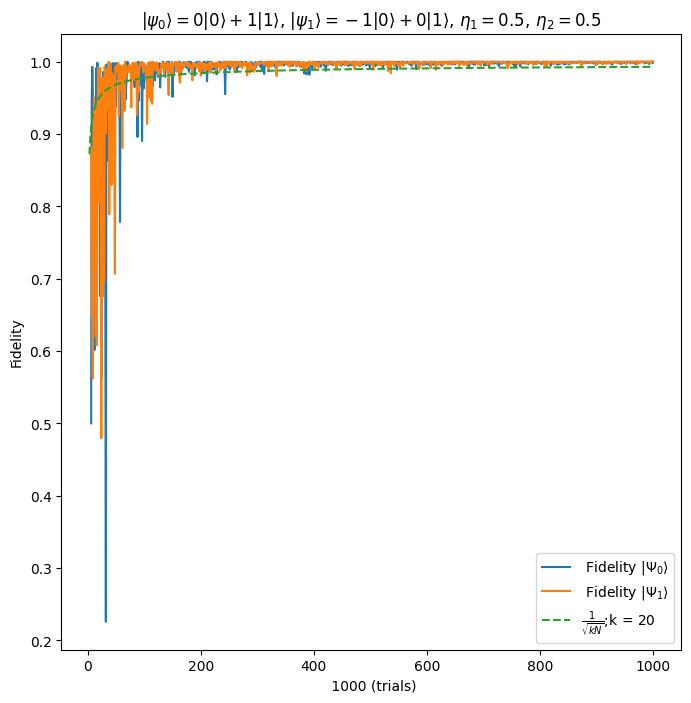

Fidelity Coverged to:  , [1, 0.9982465558785157]


In [793]:
# plots
c90 = [0,1,1,0]
c90e = [0,1,-1,0]
# c450 = [.707,.707,0,1]
# c45e = [-.707,.707,-1,0]
c3 = [-1,0,.707,.707]
c4 = [(2**.5)/(3**.5),1/(3**.5),.707,.707]         
c5 = [1,0,1,0]   # same states   

# c_l = [c0,c1,c2,c3,c4,c5]
# for c in c_l : 
#     Plotting(c=c,N= 100000, step= 100, size=[4,4])


# Plotting(c=c90, N=1000, step= 1, size=[8,8], k =20)
Plotting(c=c90e, N=1000, step= 1, size=[8,8], k =20)
